<a href="https://colab.research.google.com/github/Anjasfedo/Learning-TensorFlow/blob/main/eat_tensorflow2_in_30_days/Chapter6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6-1 Three Ways of Modeling

There are three ways of modeling:
- Using `Sequential` to construct model with the order of layerr.
- Using functional APIs to construct model with arbitary structure.
- Using child class inheriting from base class `Model`.

For the models with sequenced structure, `Sequential` method should be given the highest priority.

For the models with non-sequential structure such as multiple input/output, shared weights, or resdual connections, modeling with functional API is recommended.

Modeling through child class of `Model` shoud be AVOIDE unless with special requirements. This method is flexible, but also fallible.

Here is the example of modeling using the three above-mentioned methods to classify IMDB movie reviews.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tqdm import tqdm

In [2]:
!git clone https://github.com/lyhue1991/eat_tensorflow2_in_30_days.git

Cloning into 'eat_tensorflow2_in_30_days'...
remote: Enumerating objects: 14635, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 14635 (delta 8), reused 8 (delta 4), pack-reused 14617
Receiving objects: 100% (14635/14635), 59.88 MiB | 13.25 MiB/s, done.
Resolving deltas: 100% (13241/13241), done.
Updating files: 100% (12529/12529), done.


In [3]:
train_token_path = "/content/eat_tensorflow2_in_30_days/data/imdb/train_token.csv"
test_token_path = "/content/eat_tensorflow2_in_30_days/data/imdb/test_token.csv"

In [4]:
MAX_WORDS = 10000 # only consider the top 10k words in the dataset
MAX_LEN = 200 # cut reviews after 200 words
BATCH_SIZE = 20

In [5]:
# Constructing data pipeline
def parse_line(line):
  t = tf.strings.split(line, sep="\t")
  label = tf.reshape(tf.cast(tf.strings.to_number(t[0]), tf.int32), (-1,))
  features = tf.cast(tf.strings.to_number(tf.strings.split(t[1], sep=" ")), tf.int32)
  return (features, label)

ds_train = tf.data.TextLineDataset(filenames=[train_token_path]) \
          .map(parse_line, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
          .shuffle(buffer_size=1000).batch(BATCH_SIZE) \
          .prefetch(tf.data.experimental.AUTOTUNE)

ds_test = tf.data.TextLineDataset(filenames=[test_token_path]) \
          .map(parse_line, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
          .shuffle(buffer_size=1000).batch(BATCH_SIZE) \
          .prefetch(tf.data.experimental.AUTOTUNE)

## 1. Modeling Using `Sequential`

In [6]:
tf.keras.backend.clear_session()

model = models.Sequential()

model.add(layers.Embedding(MAX_WORDS, 7, input_length=MAX_LEN))
model.add(layers.Conv1D(filters=64, kernel_size=5, activation="relu"))
model.add(layers.MaxPool1D(2))
model.add(layers.Conv1D(filters=32, kernel_size=3, activation="relu"))
model.add(layers.MaxPool1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(optimizer='Nadam',
            loss='binary_crossentropy',
            metrics=['accuracy',"AUC"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 7)            70000     
                                                                 
 conv1d (Conv1D)             (None, 196, 64)           2304      
                                                                 
 max_pooling1d (MaxPooling1  (None, 98, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 32)            6176      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 48, 32)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 1536)              0

In [7]:
import datetime

logdir = "/content/data/keras_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
history = model.fit(ds_train,
                    validation_data=ds_test,
                    epochs=6,
                    callbacks=[tensorboard_callback])

Epoch 1/6
1000/1000 [==============================] - 20s 17ms/step - loss: 0.4560 - accuracy: 0.7527 - auc: 0.8573 - val_loss: 0.3460 - val_accuracy: 0.8512 - val_auc: 0.9446
Epoch 2/6
1000/1000 [==============================] - 11s 11ms/step - loss: 0.2186 - accuracy: 0.9135 - auc: 0.9710 - val_loss: 0.3358 - val_accuracy: 0.8694 - val_auc: 0.9431
Epoch 3/6
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1360 - accuracy: 0.9485 - auc: 0.9883 - val_loss: 0.4229 - val_accuracy: 0.8630 - val_auc: 0.9336
Epoch 4/6
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0780 - accuracy: 0.9722 - auc: 0.9957 - val_loss: 0.7028 - val_accuracy: 0.8432 - val_auc: 0.9140
Epoch 5/6
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0394 - accuracy: 0.9868 - auc: 0.9988 - val_loss: 0.7861 - val_accuracy: 0.8550 - val_auc: 0.9088
Epoch 6/6
1000/1000 [==============================] - 15s 15ms/step - loss: 0.0239 - accuracy: 0.9923 - auc: 0.999

In [8]:
import matplotlib.pyplot as plt

def plot_metric(history, metric):
  train_metrics = history.history[metric]
  val_metrics = history.history['val_'+metric]
  epochs = range(1, len(train_metrics) + 1)
  plt.plot(epochs, train_metrics, 'bo--')
  plt.plot(epochs, val_metrics, 'ro-')
  plt.title('Training and validation '+ metric)
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend(["train_"+metric, 'val_'+metric])
  plt.show()

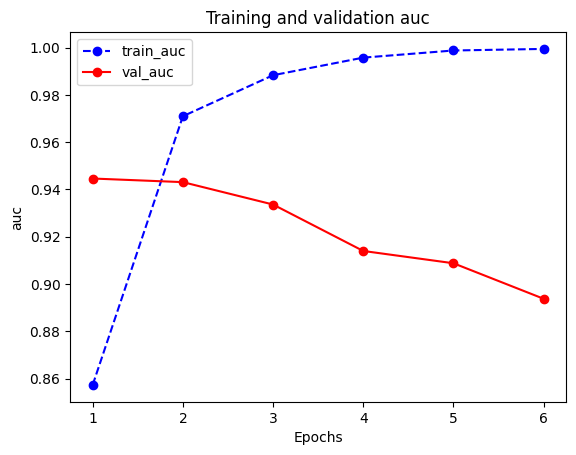

In [9]:
plot_metric(history,"auc")

## 2. Modeling Using Functional API

In [10]:
tf.keras.backend.clear_session()

inputs = layers.Input(shape=[MAX_LEN])
x = layers.Embedding(MAX_WORDS, 7)(inputs)

branch1 = layers.SeparableConv1D(64, 3, activation="relu")(x)
branch1 = layers.MaxPool1D(3)(branch1)
branch1 = layers.SeparableConv1D(32, 3, activation="relu")(branch1)
branch1 = layers.GlobalMaxPool1D()(branch1)

branch2 = layers.SeparableConv1D(64, 5, activation="relu")(x)
branch2 = layers.MaxPool1D(5)(branch2)
branch2 = layers.SeparableConv1D(32, 5, activation="relu")(branch2)
branch2 = layers.GlobalMaxPool1D()(branch2)

branch3 = layers.SeparableConv1D(64, 7, activation="relu")(x)
branch3 = layers.MaxPool1D(7)(branch3)
branch3 = layers.SeparableConv1D(32, 7, activation="relu")(branch3)
branch3 = layers.GlobalMaxPool1D()(branch3)

concat = layers.Concatenate()([branch1, branch2, branch3])
outputs = layers.Dense(1, activation="sigmoid")(concat)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='Nadam',
            loss='binary_crossentropy',
            metrics=['accuracy',"AUC"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 200, 7)               70000     ['input_1[0][0]']             
                                                                                                  
 separable_conv1d (Separabl  (None, 198, 64)              533       ['embedding[0][0]']           
 eConv1D)                                                                                         
                                                                                                  
 separable_conv1d_2 (Separa  (None, 196, 64)              547       ['embedding[0][0]']       

In [11]:
history_2 = model.fit(ds_train,
                    validation_data=ds_test,
                    epochs=6,
                    callbacks=[tensorboard_callback])

Epoch 1/6
1000/1000 [==============================] - 23s 20ms/step - loss: 0.5926 - accuracy: 0.6588 - auc: 0.7411 - val_loss: 0.3968 - val_accuracy: 0.8302 - val_auc: 0.9055
Epoch 2/6
1000/1000 [==============================] - 16s 16ms/step - loss: 0.3029 - accuracy: 0.8722 - auc: 0.9444 - val_loss: 0.3422 - val_accuracy: 0.8568 - val_auc: 0.9312
Epoch 3/6
1000/1000 [==============================] - 17s 16ms/step - loss: 0.1704 - accuracy: 0.9345 - auc: 0.9825 - val_loss: 0.4005 - val_accuracy: 0.8548 - val_auc: 0.9269
Epoch 4/6
1000/1000 [==============================] - 16s 16ms/step - loss: 0.0820 - accuracy: 0.9761 - auc: 0.9956 - val_loss: 0.5451 - val_accuracy: 0.8454 - val_auc: 0.9159
Epoch 5/6
1000/1000 [==============================] - 16s 16ms/step - loss: 0.0294 - accuracy: 0.9937 - auc: 0.9990 - val_loss: 0.6651 - val_accuracy: 0.8466 - val_auc: 0.9087
Epoch 6/6
1000/1000 [==============================] - 16s 16ms/step - loss: 0.0084 - accuracy: 0.9991 - auc: 0.999

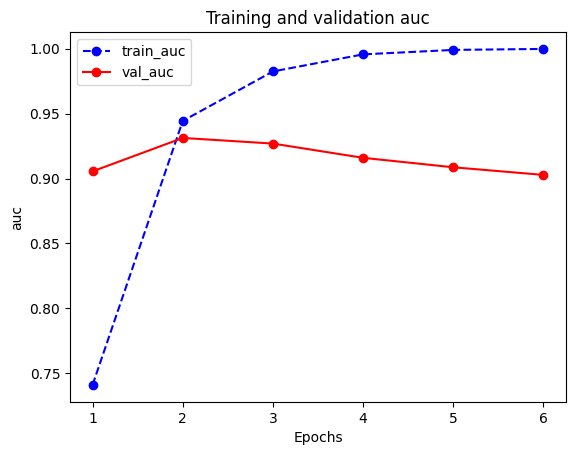

In [12]:
plot_metric(history_2,"auc")

## 3. Customized Modeling Using Child Class of `Model`

In [15]:
# Customized residual module as layer
class ResBlock(layers.Layer):
  def __init__(self, kernel_size, **kwargs):
    super(ResBlock, self).__init__(**kwargs)
    self.kernel_size = kernel_size

  def build(self, input_shape):
    self.conv1 = layers.Conv1D(filters=64,
                               kernel_size=self.kernel_size,
                               activation="relu",
                               padding="same")
    self.conv2 = layers.Conv1D(filters=32,
                               kernel_size=self.kernel_size,
                               activation="relu",
                               padding="same")
    self.conv3 = layers.Conv1D(filters=input_shape[-1],
                               kernel_size=self.kernel_size,
                               activation="relu",
                               padding="same")
    self.maxpool = layers.MaxPool1D(2)
    super(ResBlock, self).build(input_shape)

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.conv2(x)
    x = self.conv3(x)
    x = layers.Add()([inputs, x])
    x = self.maxpool(x)
    return x

  # Need to define get_config method in order to sequentialize the model construced from customized Layer by Functional API
  def get_config(self):
    config = super(ResBlock, self).get_config()
    config.update({'kernel_size': self.kernel_size})
    return config

In [16]:
# Test resblock
resblock = ResBlock(kernel_size=3)
resblock.build(input_shape=(None, 200, 7))
resblock.compute_output_shape(input_shape=(None, 200, 7))

TensorShape([None, 100, 7])

In [17]:
# Customized model, which cloud also be implemented by Sequential or Functional API

class ImdbModel(models.Model):
  def __init__(self):
    super(ImdbModel, self).__init__()

  def build(self, input_shape):
    self.embedding = layers.Embedding(MAX_WORDS, 7)
    self.block1 = ResBlock(7)
    self.block2 = ResBlock(5)
    self.dense = layers.Dense(1, activation="sigmoid")
    super(ImdbModel, self).build(input_shape)

  def call(self, x):
    x = self.embedding(x)
    x = self.block1(x)
    x = self.block2(x)
    x = layers.Flatten()(x)
    x = self.dense(x)
    return x

In [19]:
tf.keras.backend.clear_session()

model = ImdbModel()
model.build(input_shape=(None, 200))
model.summary()

model.compile(optimizer="Nadam",
              loss="binary_crossentropy",
              metrics=["accuracy", "AUC"])

Model: "imdb_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  70000     
                                                                 
 res_block (ResBlock)        multiple                  19143     
                                                                 
 res_block_1 (ResBlock)      multiple                  13703     
                                                                 
 dense (Dense)               multiple                  351       
                                                                 
Total params: 103197 (403.11 KB)
Trainable params: 103197 (403.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
history_3 = model.fit(ds_train,
                    validation_data=ds_test,
                    epochs=6,
                    callbacks=[tensorboard_callback])

Epoch 1/6
1000/1000 [==============================] - 29s 27ms/step - loss: 0.5055 - accuracy: 0.7078 - auc: 0.8117 - val_loss: 0.3057 - val_accuracy: 0.8706 - val_auc: 0.9438
Epoch 2/6
1000/1000 [==============================] - 23s 23ms/step - loss: 0.2337 - accuracy: 0.9043 - auc: 0.9667 - val_loss: 0.3250 - val_accuracy: 0.8694 - val_auc: 0.9457
Epoch 3/6
1000/1000 [==============================] - 24s 24ms/step - loss: 0.1362 - accuracy: 0.9495 - auc: 0.9883 - val_loss: 0.3940 - val_accuracy: 0.8614 - val_auc: 0.9369
Epoch 4/6
1000/1000 [==============================] - 23s 23ms/step - loss: 0.0688 - accuracy: 0.9753 - auc: 0.9965 - val_loss: 0.6323 - val_accuracy: 0.8592 - val_auc: 0.9188
Epoch 5/6
1000/1000 [==============================] - 23s 23ms/step - loss: 0.0396 - accuracy: 0.9859 - auc: 0.9986 - val_loss: 0.7362 - val_accuracy: 0.8496 - val_auc: 0.9138
Epoch 6/6
1000/1000 [==============================] - 23s 23ms/step - loss: 0.0239 - accuracy: 0.9919 - auc: 0.999

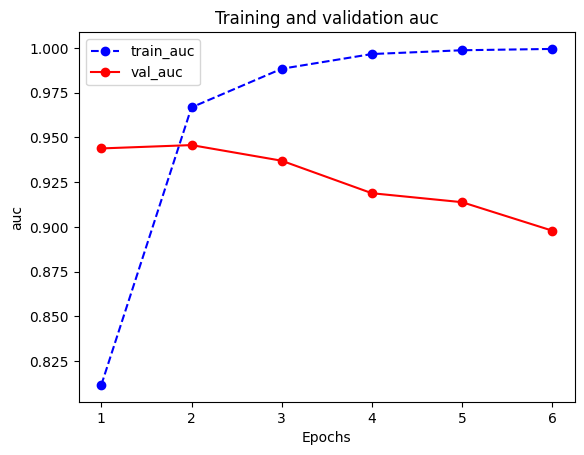

In [21]:
plot_metric(history_3,"auc")